# カルマンフィルタによる状態の補正（推定）

## カルマンフィルタの要点**
- 線形ガウス状態空間モデルにおいて使用される状態の推定方法
- 何をやっているかというと、<font color="red">状態方程式による当期の状態推定値を、当期の観測値に基づいて修正する</font>こと
- 状態方程式・観測方程式のパラメータは事前に推定しておいたものを使う(05_param_estimate 参照)

## カルマンフィルタ適用の手順
- 以下の補正式により修正する
    - 補正後の状態 = 補正前の状態 ＋ カルマンゲイン × 観測値の予測誤差
    - ただし、観測値の予測誤差 = 本物の観測値 - 予測された観測値
    - 予測が実際より大きくなっていたら、状態推定値を小さくするように補正する<br>
      → 補正後の状態に基づいて推定される観測値は、補正前より小さくなり、観測値の予測誤差が改善してるはず<br><br>
      
    - カルマンゲイン = 状態の予測誤差の分散 ÷ (状態の予測誤差の分散 + 観測方程式のノイズの分散) $\le$ 1 (高々1)
         - 状態をどれほど調整すべきか、その程度を示す
        - 状態の予測が精度良い（予測誤差の分散 小）なら、元から正しい状態に違いないから、あんま修正しないようにする: ゲイン 小
            - 状態の予測誤差の分散とゲインはおおよそ比例すべき
        - 観測誤差が小さい（観測方程式のノイズの分散 小）なら、観測値の予測誤差の大きさに応じて状態を修正すべきとなる: ゲイン 大
            - 観測誤差の分散とゲインはおおよそ反比例すべき<br><br>
            
    - 状態の予測誤差の分散の時間経過
        - 単に、長期的な予測を行うと、どんどん状態方程式のノイズが加算されていくので、誤差の分散もまたどんどん大きくなっていく
            - "今期の状態の予測誤差の分散 = 前期の状態の予測誤差の分散 + 状態方程式のノイズの分散" のような感じで
        - ただ、カルマンフィルタによる状態の補正が入ると、予測誤差の分散が小さくなるはず
            - ということで、以下の式に倣って「状態の予測誤差の分散」も補正する
            - 状態の予測誤差の分散_補正後 = (１ - カルマンゲイン) × 状態の予測誤差の分散_補正前
            - 基本的には分散が小さくなるような補正
            - カルマンゲインが小さい（あまり状態を補正しない）場合、予測誤差の分散も補正がされない

## カルマンフィルタをデータ（Air-Passengers）で試す

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# グラフを横長にする
plt.rcParams['figure.figsize'] = 15, 6
# 文字サイズの指定
plt.rcParams["font.size"] = 18

### データの用意

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv',
                                    index_col='Month', parse_dates=True,  dtype='float')
ts = data['Passengers']

### 線形ガウス状態空間モデルにローカルレベルモデルを想定

**状態方程式**: $x_t = x_{t-1} + \varepsilon_t$<br>
**観測方程式**: $y_t = x_{t} + \eta_t$

- 入力
    - y: 当該時点の観測値
    - x_pre: 1時点前の状態推定値
    - x_err_var_pre: 1時点前の状態の予測誤差の分散
    - sigma_y: 観測方程式の誤差項の分散 ($\eta_t$の分散)
    - sigma_x: 状態方程式の誤差項の分散 ($\varepsilon_t$の分散)
- 出力
    - x_current: 当該時点の状態の推定値（カルマンフィルタ適用後）
    - x_err_var_current: 当該時点の状態の予測誤差の分散（カルマンフィルタによる状態の補正を考慮）
    - y_pred: 当該時点の観測値の推定結果（カルマンフィルタ適用前の状態に基づく）

In [4]:
def local_level_model(y, x_pre, x_err_var_pre, sigma_y, sigma_x):
    # 今期の状態の予測　（状態方程式により算出）
    x_current = x_pre + np.random.normal(loc=0, scale=np.sqrt(sigma_x))
    
    # 今期の状態の推定値から観測値を予測
    y_pred = x_current + np.random.normal(loc=0, scale=np.sqrt(sigma_y))
    
    # 今期の予測誤差の分散 = 前期の予測誤差の分散 + 状態方程式のノイズの分散
    x_err_var_current = x_err_var_pre + sigma_x
    
    # カルマンゲイン: 状態をどんくらい補正するか
    k_gain = x_err_var_current / (x_err_var_current + sigma_y)
    
    # 状態の補正
    x_current += k_gain * (y - y_pred)
    
    # 状態の予測誤差の分散の修正
    x_err_var_current *= (1 - k_gain)
    
    return x_current, x_err_var_current, y_pred

### 適当にパラメータいじれるように関数化
本来は事前にパラメータを推定しておくが、今回は手作業でいろいろいじってみる

In [5]:
def k_filter(data, x_0, x_err_var_0, sigma_x, sigma_y):
    # 状態, 初期値は x_0
    x = ts.copy()

    # 観測値の推定結果
    ts_pred = ts.copy()

    # 状態の予測誤差の分散, 初期値は x_err_var_0
    x_err_var = np.append(x_err_var_0, np.zeros(len(ts)))
    
    # カルマンフィルタによる状態の補正（推定）
    for i in range(len(ts)):
        if i == 0:
            x[i], x_err_var[i+1], ts_pred[i] = local_level_model(ts[i], x_0, x_err_var[i], sigma_y=sigma_y, sigma_x=sigma_x)
        else:
            x[i], x_err_var[i+1], ts_pred[i] = local_level_model(ts[i], x[i-1], x_err_var[i], sigma_y=sigma_y, sigma_x=sigma_x)

    return x, ts_pred

### 観測方程式の分散をいじってみる

**理論的な見解**
- 分散が大きい　→　観測方程式による推定値が信用できない → カルマンゲインが小さい（誤差は状態のせいじゃない、観測誤差のせい）
    - 状態方程式の分散を下記では 1e-3 と小さく設定しているため、状態の遷移は青線のようにほぼ変わらない結果に
- 分散が小さい → 観測方程式による推定値がそこそこ信頼できる → カルマンゲインが大きい（誤差は状態の予測誤差のせいだろと判断）
    - 青線と比較して、状態が観測値に近づいていく

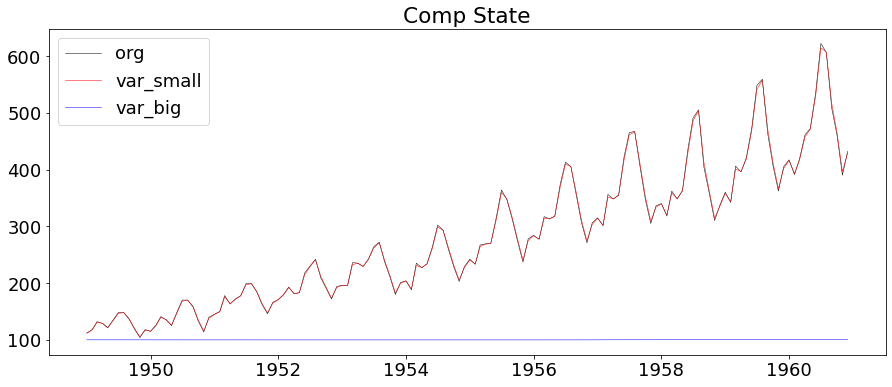

In [6]:
x1, ts_pred1 = k_filter(ts, x_0=100, x_err_var_0=1e-3, sigma_x=1e-3, sigma_y=1e-4)
x2, ts_pred2 = k_filter(ts, x_0=100, x_err_var_0=1e-3, sigma_x=1e-3, sigma_y=1e4)

plt.title("Comp State")
plt.plot(ts, 'k', linewidth=0.5, label='org')
plt.plot(x1, 'r', linewidth=0.5, label='var_small')
plt.plot(x2, 'b', linewidth=0.5, label='var_big')
plt.legend()

### 状態方程式の分散をいじってみる

**理論的な見解**
- 分散が大きい　→　状態方程式による状態の推定値が信用できない → 状態の補正量が大きい
    - 観測値に状態が近づく（観測方程式の誤差が 1e-3 と小さく設定していることにも起因した結果）：青線
- 分散が小さい → 状態方程式による状態の推定値がそこそこ信頼できる → 状態の補正量が小さい
    - 観測値と状態はあまり似ない：赤線

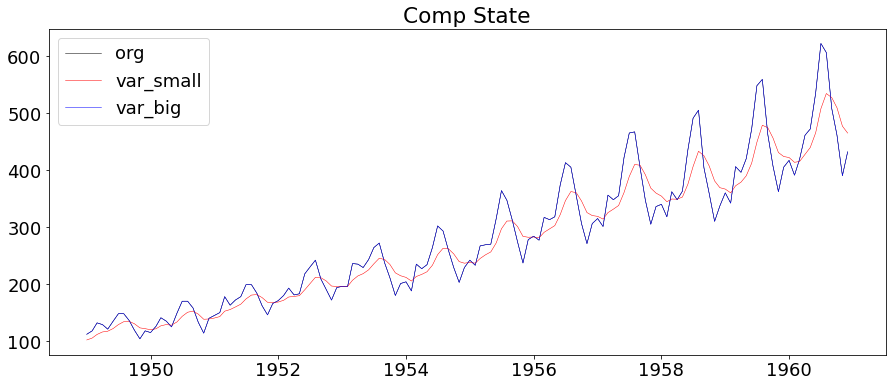

In [7]:
x1, ts_pred1 = k_filter(ts, x_0=100, x_err_var_0=1e-4, sigma_x=1e-4, sigma_y=1e-3)
x2, ts_pred2 = k_filter(ts, x_0=100, x_err_var_0=1e4, sigma_x=1e4, sigma_y=1e-3)

plt.title("Comp State")
plt.plot(ts, 'k', linewidth=0.5, label='org')
plt.plot(x1, 'r', linewidth=0.5, label='var_small')
plt.plot(x2, 'b', linewidth=0.5, label='var_big')
plt.legend()